This is the evaluation file for the models that was trained, models are loaded in here and tested with calculation of
their performance metric such as DICE coefficient.

Also it compares the plot of a slice of predicted label vs actual label

Saves a final complete predicted label.

In [1]:
import os
import shutil
import tempfile
import torch
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,

)

from monai.config import print_config
from monai.metrics import DiceMetric

from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
print_config()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.21.0
scipy version: 1.8.0
Pillow version: 9.0.1
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 1.3.5
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory (For saving and loading of data)
## If not specified a temporary directory will be used.

In [2]:
directory = '/home/katan/'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/katan/


## Setup Transformer


In [3]:
train_transforms = Compose(
    [

        # Loads images and corresponding labels from the specified keys.
        LoadImaged(keys=["image", "label"]),
                         
        #Ensures that the channel dimension is the first dimension in both the image and label arrays.
        EnsureChannelFirstd(keys=["image", "label"]),
        #Reshapes the image and label arrays according to the provided orientation codes ("RAS" in this case),
        #ensuring consistent orientation across different images.
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #’RAS’ represents 3D orientation: (Left, Right), (Posterior, Anterior), (Inferior, Superior).
          Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),  # Adjusted for the new volume sizes
            mode=("bilinear", "nearest"),
        ),
        
        #Scales the intensity values of the images within a specified range (a_min to a_max) to a new range (b_min to b_max). 
        #It's commonly used for normalization.
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

        #Crops the foreground (non-zero intensity regions) of the images and corresponding labels.
        #It uses the source key "image" to determine the foreground region.
        #good when the valid part is small in the image
        CropForegroundd(keys=["image", "label"], source_key="image"),


        #Performs random cropping based on positive and negative labels. 
        #It selects random spatial locations based on the specified spatial size and the number of positive and negative samples.
                         
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        #Randomly flips the images and labels along the specified spatial axis with a given probability.
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        # Randomly rotates the images and labels by 90 degrees multiples, with a specified probability (prob) and maximum number of rotations (max_k=3).
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        # Randomly shifts the intensity values of the images within a specified offset range (offsets) with a given probability.
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 0),  # Adjusted for the new volume sizes
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


# Set up data directory

In [4]:
data_dir = '/home/katan/Dataset/'
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=32,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=8, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


# Check data shape and visualize


image shape: torch.Size([1, 135, 131, 224]), label shape: torch.Size([1, 135, 131, 224])


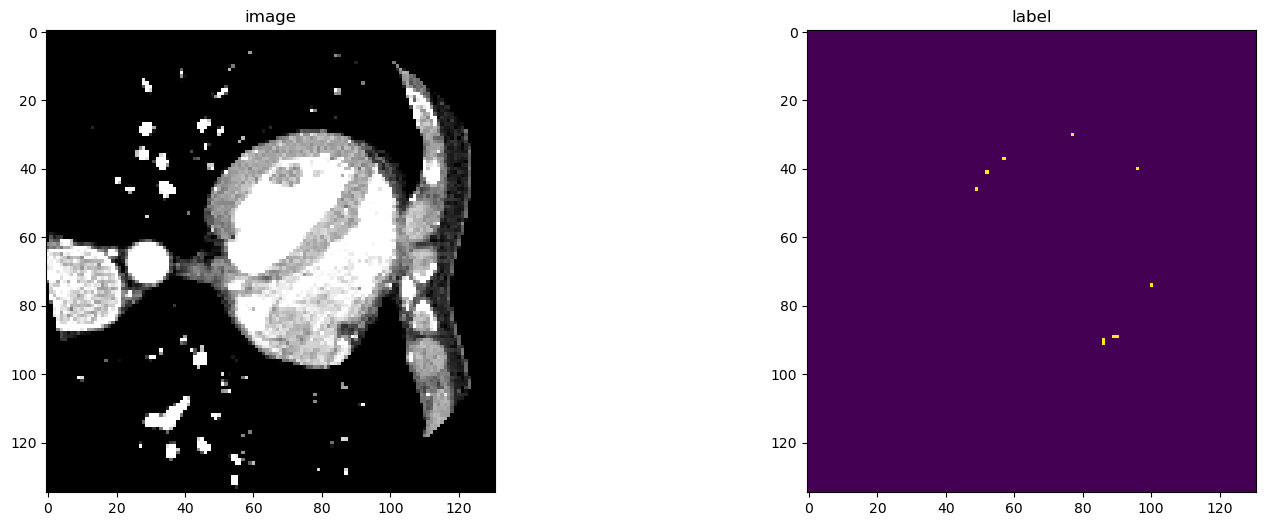

In [5]:
slice_map = {
    "Diseased_1.nrrd": 45,
    "Diseased_2.nrrd": 23,
    "Diseased_17.nrrd": 112,
    "Normal_1.nrrd": 79,
    "Normal_4.nrrd": 23,
    "Normal_6.nrrd": 64,
    
}
case_num = 0

#Validation Set
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
# Save the plot
plt.savefig('plot0_25k.png') 
plt.show()



# Create Model



In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

if torch.cuda.is_available():
    print("CUDA is available. You can use GPU acceleration.")
else:
    print("CUDA is not available. GPU acceleration is not possible.")

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)



monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.


CUDA is available. You can use GPU acceleration.
2.3.0+cu121
cuda


# Calculation of Final performance metrics

In [7]:
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)

def calculate_dice_for_best_model(model, val_loader):
    model.eval()
    with torch.no_grad():
        dice_metric = DiceMetric(include_background=False)
        for batch in val_loader:
            val_inputs, val_labels = batch["image"].cuda(), batch["label"].cuda()
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def load_best_model_and_calculate_dice(model, val_loader, best_model_path):
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
        mean_dice_val = calculate_dice_for_best_model(model, val_loader)
        print("Dice coefficient for the best model: ", mean_dice_val)
    else:
        print("Best model file not found.")

# Example usage:
best_model_path = os.path.join(root_dir, "model_25k.pth")
load_best_model_and_calculate_dice(model, val_loader, best_model_path)

Dice coefficient for the best model:  0.7629017233848572


# Check best model output with the input image and label


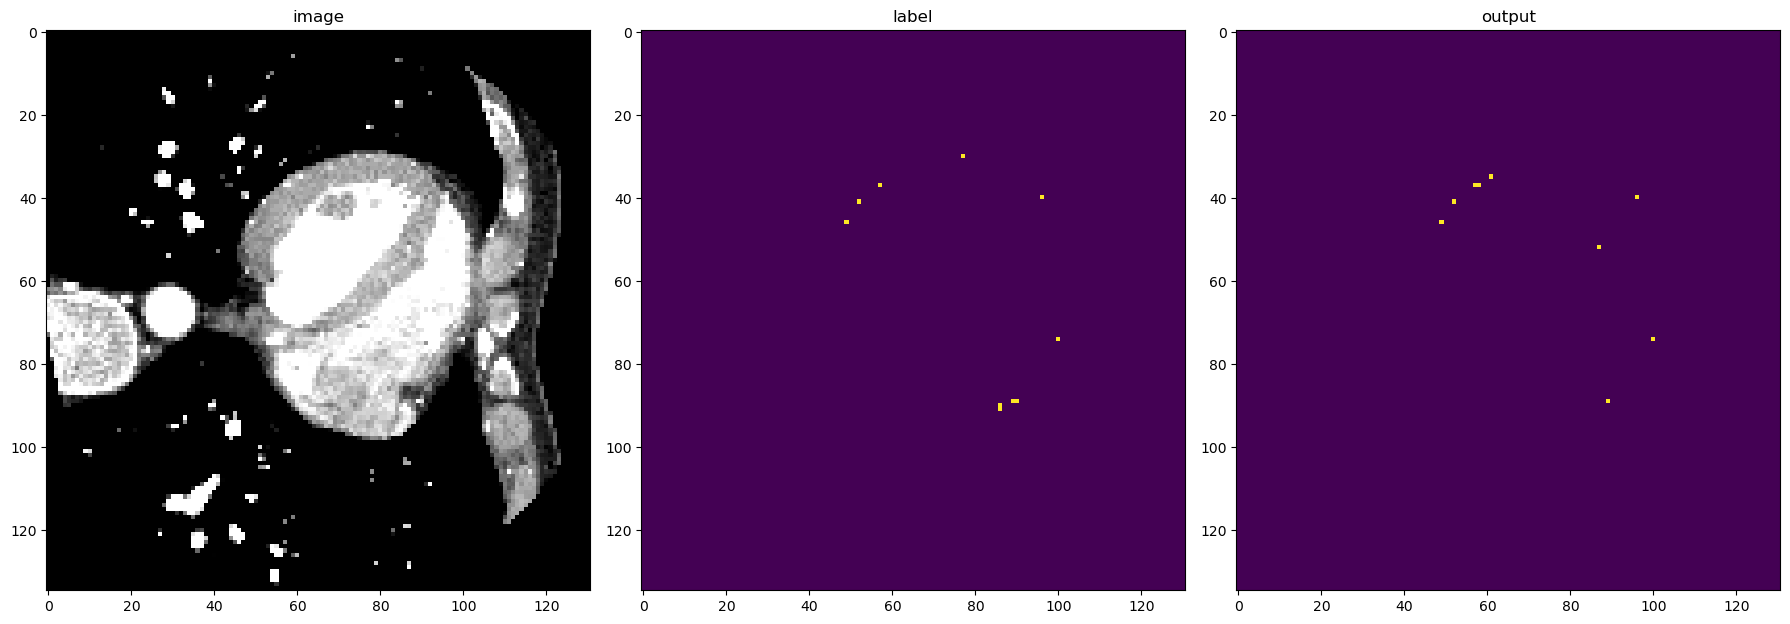

In [8]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(root_dir, "model_25k.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    # Adjust layout to prevent overlapping titles
    plt.tight_layout()

    # Save the plot
    plt.savefig('plot2_25k.png')  

    plt.show()

# Saving the output 3d image

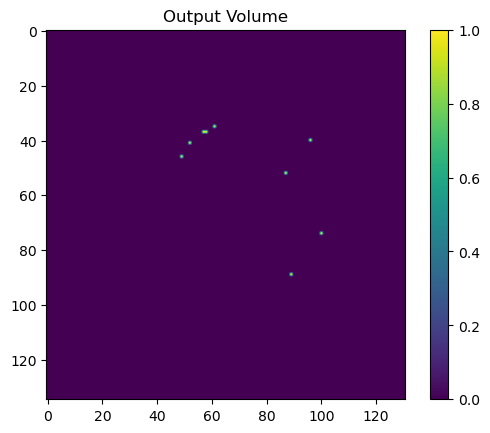

In [9]:

case_num = 0
model.load_state_dict(torch.load(os.path.join(root_dir, "model_25k.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)

    # Stack slices along the specified dimension
    output_volume = torch.argmax(val_outputs, dim=1).detach().cpu()

    # Save the 3D volume as an image
    output_volume_np = output_volume.numpy()
    output_volume_np = np.moveaxis(output_volume_np, 0, -1)  # Move channel dimension to the last
    output_volume_np = np.squeeze(output_volume_np)  # Remove singleton channel dimension if present

    # Save the 3D volume as an image file
    output_volume_img = sitk.GetImageFromArray(output_volume_np)
    sitk.WriteImage(output_volume_img, 'output_volume_25k.nii')

    # Plot the first slice for visualization
    plt.imshow(output_volume_np[:, :, slice_map[img_name]])
    plt.title("Output Volume")
    plt.colorbar()
    plt.show()
